# Colore

In [34]:
import math
from sklearn.neighbors import KNeighborsClassifier
import keras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KDTree
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

In [35]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import operator

def get_colors (image_path):
    img = cv2.imread(image_path)
    _, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    color = ('b','g','r')
    qtdBlue = 0
    qtdGreen = 0
    qtdRed = 0
    totalPixels = 0

    for channel,col in enumerate(color):
        histr = cv2.calcHist([img],[channel],None,[256],[1,256])
        totalPixels+=sum(histr)
        if channel==0:
            qtdBlue = sum(histr)
        elif channel==1:
            qtdGreen = sum(histr)
        elif channel==2:
            qtdRed = sum(histr)

    qtdBlue = (qtdBlue/totalPixels)*100
    qtdGreen = (qtdGreen/totalPixels)*100
    qtdRed = (qtdRed/totalPixels)*100

    if math.isnan(qtdBlue) == True :
        qtdBlue = np.zeros(1)
    if math.isnan(qtdGreen) == True :
        qtdGreen = np.zeros(1)
    if math.isnan(qtdRed) == True :
        qtdRed = np.zeros(1)

    colors = np.asarray([qtdBlue[0], qtdGreen[0], qtdRed[0]])
    #colors = np.expand_dims(colors, axis = 0)
    return colors

In [3]:
get_colors('mask_train/image_02916.jpg')

array([0., 0., 0.])

# SURF

! pip install opencv_contrib_python==3.4.2.17 --force-reinstall

In [39]:
import cv2

In [38]:
import cv2
print(cv2.__version__) 

3.4.2


In [37]:
def extract_keypoins (image_path):
    
    image = cv2.imread(image_path, 0)
    surf = cv2.xfeatures2d.SURF_create()
    _, features = surf.detectAndCompute(image, None)

    max_items = 300

    if features is not None:

        if len(features) < max_items:
            shape = (max_items, 64)
            features_pad = np.zeros(shape)
            features_pad[:features.shape[0],:features.shape[1]] = features
            features_crop = features_pad[:max_items]
        else:
            features_crop = features[:max_items]
    else:
        features_crop = np.zeros (max_items*64)
    features_final = features_crop.reshape(max_items*64)

    return features_final

In [36]:
def extract_keypoins_edges (image_path):
    
    image = cv2.imread(image_path, 0)
    edges = cv2.Canny(image, 500, 100)
    surf = cv2.xfeatures2d.SURF_create(1000)
    _, features = surf.detectAndCompute(edges, None)

    max_items = 300

    if features is not None:
        
        if len(features) < max_items:
            shape = (max_items, 64)
            features_pad = np.zeros(shape)
            features_pad[:features.shape[0],:features.shape[1]] = features
            features_crop = features_pad[:max_items]
        else:
            features_crop = features[:max_items]
    else:
        features_crop = np.zeros (max_items*64)
    
    features_final = features_crop.reshape(max_items*64)

    return features_final

# Neural Features

In [40]:
import os
import numpy as np
from keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [8]:
net = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='max', input_shape=(224,224,3))

In [9]:
netvgg = VGG16(weights='imagenet')

In [10]:
feature_extractor1 = Model(inputs = net.inputs, outputs = net.get_layer('block_2_add').output)

In [11]:
feature_extractor2 = Model(inputs = netvgg.inputs, outputs = netvgg.get_layer('block3_pool').output)

In [12]:
def neural_features(image_path):
    img = kimage.load_img(image_path, target_size=(224, 224))
    x = kimage.img_to_array(img)
    x = mobilenet_v2.preprocess_input(x)
    x = np.expand_dims(x, axis = 0)
    features = netvgg.predict(x) #features = feature_extractor1.predict(x) feature_extractor2.predict(x) net.predict(x) netvgg.predict(x)
    features = features.flatten()   
    return features


# Combine features

In [13]:
def combo_colors_kps_neural(image_path):

  colors = get_colors(image_path)
  #print(colors.shape)

  kps = extract_keypoins_edges(image_path)
  #print(kps.shape)

  neural = neural_features (image_path)
  #print(neural.shape)

  return np.concatenate((colors, kps, neural))

In [14]:
def combo_colors_kps(image_path):

    colors = get_colors(image_path)
    
    kps = extract_keypoins_edges(image_path)
    
    return np.concatenate((colors, kps))

In [15]:
def combo_colors_neural(image_path):

    colors = get_colors(image_path)
    
    neural = neural_features (image_path)
    
    return np.concatenate((colors, neural))

# Load Data

In [16]:
# Debug variable to limit the number of loaded images
#maximages = 1022

# Dummy feature
def identity(image):
    return kimage.img_to_array(img).flatten()

# Data loader
def load_data(folder, feature_extractor=identity, maximages = 'default' ):
    if maximages == 'default':
        maximages = len(os.listdir(folder))+1

    base_path = folder

    features = []

    for index, image in enumerate(sorted(os.listdir(base_path))):
        print ('image', index)
        if index < maximages:
            image_path = base_path+image
            # Load file and extract features
            cur_features = feature_extractor(image_path)
            cur_features = cur_features.flatten()
            features.append(cur_features)

    #features = np.array(features)
    return features

In [26]:
X_train_features = load_data('mask_train/',feature_extractor=combo_colors_kps_neural)
with open('X_train_features_colors_kps_neural.pickle', 'wb') as handle:
    pickle.dump(X_train_features, handle)

image 822
image 823
image 824
image 825
image 826
image 827
image 828
image 829
image 830
image 831
image 832
image 833
image 834
image 835
image 836
image 837
image 838
image 839
image 840
image 841
image 842
image 843
image 844
image 845
image 846
image 847
image 848
image 849
image 850
image 851
image 852
image 853
image 854
image 855
image 856
image 857
image 858
image 859
image 860
image 861
image 862
image 863
image 864
image 865
image 866
image 867
image 868
image 869
image 870
image 871
image 872
image 873
image 874
image 875
image 876
image 877
image 878
image 879
image 880
image 881
image 882
image 883
image 884
image 885
image 886
image 887
image 888
image 889
image 890
image 891
image 892
image 893
image 894
image 895
image 896
image 897
image 898
image 899
image 900
image 901
image 902
image 903
image 904
image 905
image 906
image 907
image 908
image 909
image 910
image 911
image 912
image 913
image 914
image 915
image 916
image 917
image 918
image 919
image 920
image 921


NameError: name 'pickle' is not defined

In [31]:
with open('X_train_features_colors_kps_neural.pickle', 'wb') as handle:
    pickle.dump(X_train_features, handle)

In [19]:
import pickle
with open ('102flowers_y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)

In [20]:
num_classes = 102
yc_train = keras.utils.to_categorical(y_train-1, num_classes)

# Prova classificatore

In [32]:
classifier = KNeighborsClassifier(n_neighbors=3)
history = classifier.fit(X_train_features, np.argmax(yc_train, axis=1))

In [33]:
y_pred_train = classifier.predict(X_train_features)
confusion_matrix2_train = confusion_matrix(np.argmax(yc_train, axis=1),y_pred_train)
classification_report2_train = classification_report(np.argmax(yc_train, axis=1),y_pred_train)
classification_report_DICT_train = classification_report(np.argmax(yc_train, axis=1),y_pred_train, output_dict=True)
accuracy_block2_pool_train = classification_report_DICT_train['accuracy']
print(classification_report2_train)

          68       0.50      0.20      0.29        10
          69       0.75      0.30      0.43        10
          70       0.75      0.30      0.43        10
          71       0.40      0.20      0.27        10
          72       0.50      0.10      0.17        10
          73       0.00      0.00      0.00        10
          74       0.50      0.20      0.29        10
          75       0.33      0.10      0.15        10
          76       0.00      0.00      0.00        10
          77       0.60      0.60      0.60        10
          78       0.00      0.00      0.00        10
          79       0.50      0.30      0.37        10
          80       1.00      0.10      0.18        10
          81       0.00      0.00      0.00        10
          82       1.00      0.40      0.57        10
          83       0.00      0.00      0.00        10
          84       0.00      0.00      0.00        10
          85       0.50      0.10      0.17        10
          86       0.00     

In [36]:
print(classification_report2_train)

              precision    recall  f1-score   support

           0       0.29      0.90      0.44        10
           1       0.39      0.90      0.55        10
           2       0.28      0.90      0.43        10
           3       0.44      0.80      0.57        10
           4       0.38      1.00      0.56        10
           5       0.20      0.90      0.33        10
           6       0.60      0.90      0.72        10
           7       0.43      1.00      0.61        10
           8       0.59      1.00      0.74        10
           9       0.32      0.80      0.46        10
          10       0.45      1.00      0.62        10
          11       0.41      0.90      0.56        10
          12       0.35      0.90      0.50        10
          13       0.35      0.60      0.44        10
          14       0.44      0.70      0.54        10
          15       0.33      0.70      0.45        10
          16       0.50      0.90      0.64        10
          17       0.31    

In [34]:
print('Accuracy: ', accuracy_block2_pool_train)

Accuracy:  0.40294117647058825


SVC

In [18]:
with open('X_train_features_colors_kps_neural.pickle', 'rb') as handle:
    X_train_features = pickle.load(handle)

In [21]:
param_grid = {'C': [1e2, 5e2, 1e3],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)
clf=clf.fit(X_train_features, y_train)
y_pred = clf.predict(X_train_features)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00      1.00      1.00        10
          18       1.00    

In [22]:
print( 'Best Gamma:', clf.best_estimator_.gamma)
print( 'Best C:', clf.best_estimator_.C)

Best Gamma: 0.005
Best C: 100.0


In [23]:
with open('classif_sutrain_colors_kps_neural.pickle', 'wb') as handle:
    pickle.dump(clf, handle)

In [40]:
X_features_test = load_data(feature_extractor=combo_colors_kps_neural, folder = 'mask_test/')
with open('X_test_features_colors_kps_neural.pickle', 'wb') as handle:
    pickle.dump(X_features_test, handle)

image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28
image 29
image 30
image 31
image 32
image 33
image 34
image 35
image 36
image 37
image 38
image 39
image 40
image 41
image 42
image 43
image 44
image 45
image 46
image 47
image 48
image 49
image 50
image 51
image 52
image 53
image 54
image 55
image 56
image 57
image 58
image 59
image 60
image 61
image 62
image 63
image 64
image 65
image 66
image 67
image 68
image 69
image 70
image 71
image 72
image 73
image 74
image 75
image 76
image 77
image 78
image 79
image 80
image 81
image 82
image 83
image 84
image 85
image 86
image 87
image 88
image 89
image 90
image 91
image 92
image 93
image 94
image 95
image 96
image 97
image 98
image 99
image 100
image 101
image 102
image 103
image 104
image 105
image 106
image 107
image 108
image 109
image 110


In [24]:
with open('X_test_features_colors_kps_neural.pickle', 'rb') as handle:
    X_features_test = pickle.load(handle)

In [25]:
with open ('102flowers_y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)

In [43]:
y_pred_test = clf.predict(X_features_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.01      0.05      0.02        20
           2       0.04      0.20      0.07        40
           3       0.00      0.00      0.00        20
           4       0.12      0.19      0.15        36
           5       0.04      0.02      0.03        45
           6       0.00      0.00      0.00        25
           7       0.01      0.05      0.02        20
           8       0.19      0.12      0.15        65
           9       0.00      0.00      0.00        26
          10       0.05      0.24      0.08        25
          11       0.00      0.00      0.00        67
          12       0.30      0.19      0.23        67
          13       0.06      0.28      0.10        29
          14       0.03      0.07      0.05        28
          15       0.09      0.31      0.14        29
          16       0.05      0.19      0.07        21
          17       0.03      0.02      0.02        65
          18       0.00    

proviamo usando più dati. (scambiamo train e test)

In [28]:
param_grid = {'C': [1e2, 5e2, 1e3],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}
clf2 = SVC(kernel='rbf', class_weight='balanced', C = 1e2, gamma = 0.005)
clf2=clf2.fit(X_features_test, y_test)
y2_pred = clf2.predict(X_features_test)
print(classification_report(y_test, y2_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00        45
           6       1.00      1.00      1.00        25
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        65
           9       1.00      1.00      1.00        26
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00        67
          12       1.00      1.00      1.00        67
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        28
          15       1.00      1.00      1.00        29
          16       1.00      1.00      1.00        21
          17       1.00      1.00      1.00        65
          18       1.00    

In [29]:
with open('classif_sutest_colors_kps_neural.pickle', 'wb') as handle:
    pickle.dump(clf2, handle)

In [82]:
y_pred_train2 = clf2.predict(X_train_features)
print(classification_report(y_train, y_pred_train2))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.20      0.30      0.24        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.22      0.40      0.29        10
          13       0.23      0.30      0.26        10
          14       0.00      0.00      0.00        10
          15       0.50      0.20      0.29        10
          16       0.00      0.00      0.00        10
          17       0.14      0.10      0.12        10
          18       0.00    

In [97]:
with open('classif_sutrain_colors_kps_neural.pickle', 'rb') as handle:
    classif = pickle.load(handle)

In [115]:
image_path = 'mask_train/image_06057.jpg'
image = cv2.imread(image_path)
features=[]
im_features = combo_colors_kps_neural(image_path)
im_features = im_features.flatten()
features.append(im_features)

error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\imgproc\src\histogram.cpp:152: error: (-215:Assertion failed) j < nimages in function 'cv::histPrepareImages'


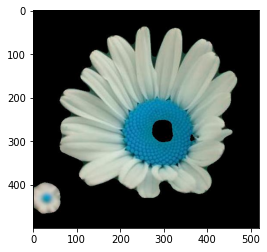

In [84]:
plt.imshow(image)

In [94]:
NAMES[clf2.predict(features)[0]]

'tree poppy'

In [99]:
def predict_name(image_path, classifier):
    image = cv2.imread(image_path)
    features=[]
    im_features = combo_colors_kps_neural(image_path)
    im_features = im_features.flatten()
    features.append(im_features)

    prediction = classifier.predict(features)[0]
    return NAMES[prediction-1]


In [119]:
predict_name('mask_val/image_08069.jpg', clf2)

'passion flower'

In [120]:
predict_name('mask_val/image_08069.jpg', classif)

'hard-leaved pocket orchid'

In [55]:
NAMES = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

In [77]:
min(y_train)

1

In [87]:
NAMES[68]

'windflower'

In [ ]:
y_pred_train2 = clf.predict(X_train_features)

# Prova CBIR

In [713]:
X_train_features_arr = np.asarray(X_train_features)

In [714]:
tree = KDTree(X_train_features_arr)
#query_image = kimage.load_img('images/cat_spot.jpg', target_size=(224,224))


In [715]:
X_train_features_arr = np.asarray(X_train_features)
tree = KDTree(X_train_features_arr)

In [800]:
query_image = '102flowers/image_00857.jpg'
query_features = combo_lite(query_image)
query_features = np.expand_dims(query_features, axis=0)
dist, ind = tree.query(query_features, k=2)

#kimage.load_img(paths[ind[0][0]])

In [724]:
list_images = os.listdir('mask_train/')

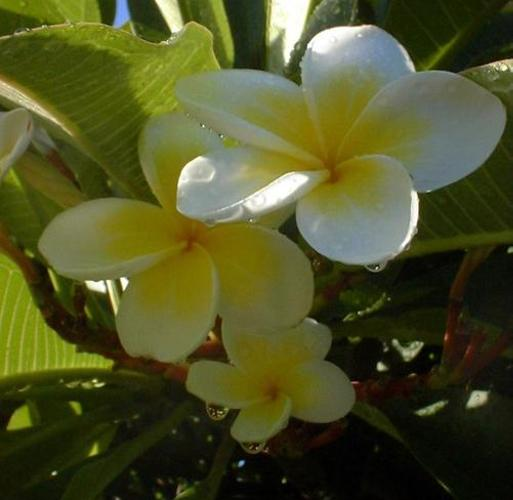

In [801]:
kimage.load_img(query_image)

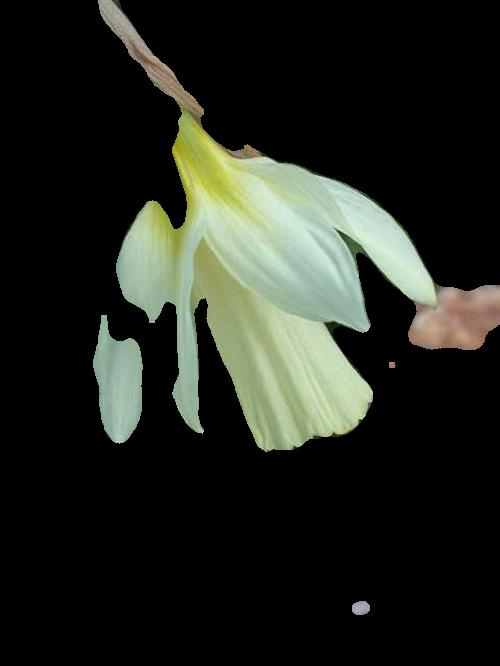

In [802]:
image_found = 'mask_train/{}'.format(list_images[ind[0][0]])
kimage.load_img(image_found)

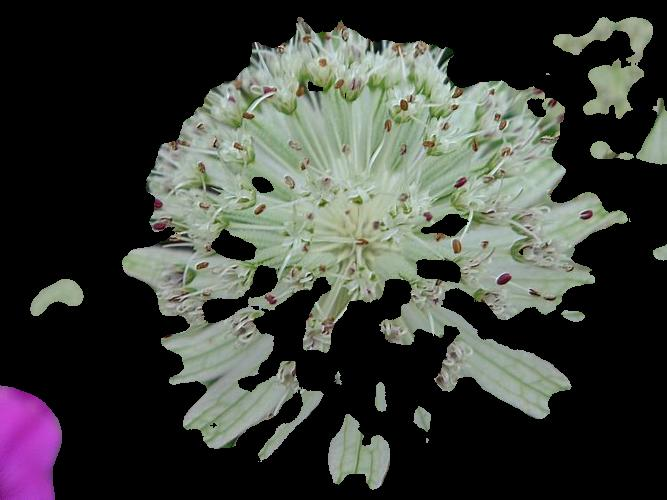

In [803]:
image_found = 'mask_train/{}'.format(list_images[ind[0][1]])
kimage.load_img(image_found)

In [542]:
edges

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

# Prove varie

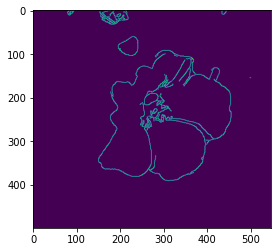

In [575]:
query_image = 'mask_test/image_00723.jpg'
image_canny = cv2.imread(query_image)
edges = cv2.Canny(image_canny, 500, 100)
plt.imshow(edges)

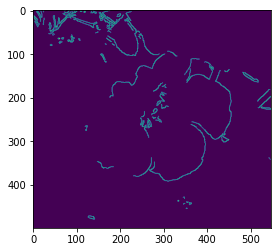

In [574]:
query_image = '102flowers/image_00723.jpg'
image_canny = cv2.imread(query_image)
edges = cv2.Canny(image_canny, 500, 300)
plt.imshow(edges)


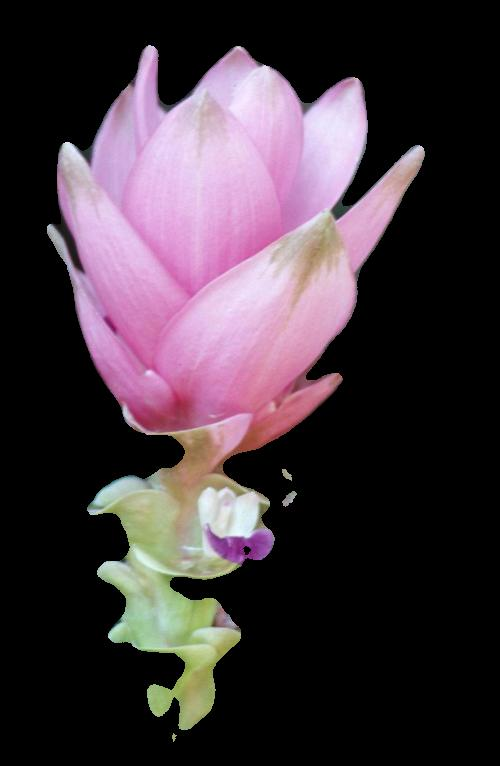

In [537]:
image_found = 'mask_train/{}'.format(list_images[ind[0][1]])
kimage.load_img(image_found)

In [603]:
print('Accuracy: ', accuracy_block2_pool_train)

Accuracy:  0.22254901960784312


In [435]:
with open ('102flowers_y_test.pickle', 'rb') as handle:
    y_test= pickle.load(handle)

In [436]:

num_classes = 102
yc_test = keras.utils.to_categorical(y_test-1, num_classes)

In [437]:
yc_test=yc_test[:9]


In [39]:
x_features_test = load_data(feature_extractor=combo_colors_kps_neural, folder = 'mask_test/')

image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28
image 29
image 30
image 31
image 32
image 33
image 34
image 35
image 36
image 37
image 38
image 39
image 40
image 41
image 42
image 43
image 44
image 45
image 46
image 47
image 48
image 49
image 50
image 51
image 52
image 53
image 54
image 55
image 56
image 57
image 58
image 59
image 60
image 61
image 62
image 63
image 64
image 65
image 66
image 67
image 68
image 69
image 70
image 71
image 72
image 73
image 74
image 75
image 76
image 77
image 78
image 79
image 80
image 81
image 82
image 83
image 84
image 85
image 86
image 87
image 88
image 89
image 90
image 91
image 92
image 93
image 94
image 95
image 96
image 97
image 98
image 99
image 100
image 101
image 102
image 103
image 104
image 105
image 106
image 107
image 108
image 109
image 110


In [227]:
y_pred = classifier.predict(x_features_test)

In [229]:
y_pred = classifier.predict(features4)
confusion_matrix2_train = confusion_matrix(np.argmax(yc_train, axis=1),y_pred)
classification_report2_train = classification_report(np.argmax(yc_train, axis=1),y_pred)
classification_report_DICT_train = classification_report(np.argmax(yc_train, axis=1),y_pred, output_dict=True)
accuracy_block2_pool_train = classification_report_DICT_train['accuracy']

In [230]:
print('Accuracy: ', accuracy_block2_pool_train)

Accuracy:  1.0
